In [1]:
#Imports
import csv
import pandas as pd
import pickle
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
from sklearn.impute import SimpleImputer
import graphviz
from graphviz import Digraph
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

<h1>Part A - Import Data</h1>

In [2]:
#Reading CSV Files
testFile = 'test.csv'
trainFile = 'train.csv'
trainDF = pd.read_csv(trainFile)
testDF = pd.read_csv(testFile)

In [3]:
#Cut Unused columns
trainDF = trainDF.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])
testDF = testDF.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])

<h1>Part B - Data Adjusting</h1>

In [4]:
#Thresholding
#Used min-max normalization for Age and Z-Score skewed up by 1 for SibSp, Parch, and Fare

#Train Data
trainDF['Age'] = (trainDF['Age']-trainDF['Age'].min())/(trainDF['Age'].max()-trainDF['Age'].min())
trainDF['SibSp'] = (trainDF['SibSp']-trainDF['SibSp'].mean())/(trainDF['SibSp'].std()) + 1
trainDF['Parch'] = (trainDF['Parch']-trainDF['Parch'].mean())/(trainDF['Parch'].std()) + 1
trainDF['Fare'] = (trainDF['Fare']-trainDF['Fare'].mean())/(trainDF['Fare'].std()) + 1
pMap = {'male': 0, 'female': 1}
trainDF['Sex'] = trainDF['Sex'].map(pMap)
newMap = {'S': 0, 'C': 1, 'Q':2}
trainDF['Embarked'] = trainDF['Embarked'].map(newMap)
trainDF = trainDF.fillna(trainDF.mean())

#Test Data
testDF['Age'] = (testDF['Age']-testDF['Age'].min())/(testDF['Age'].max()-testDF['Age'].min())
testDF['SibSp'] = (testDF['SibSp']-testDF['SibSp'].mean())/(testDF['SibSp'].std()) + 1
testDF['Parch'] = (testDF['Parch']-testDF['Parch'].mean())/(testDF['Parch'].std()) + 1
testDF['Fare'] = (testDF['Fare']-testDF['Fare'].mean())/(testDF['Fare'].std()) + 1
pMap = {'male': 0, 'female': 1}
testDF['Sex'] = testDF['Sex'].map(pMap)
newMap = {'S': 0, 'C': 1, 'Q':2}
testDF['Embarked'] = testDF['Embarked'].map(newMap)
testDF = testDF.fillna(trainDF.mean())

In [5]:
#Categorizing numerical columns
trainDF.Age = pd.cut(trainDF.Age, bins=[0, .2, .4, .6, .8, 1], labels=[.2, .4, .6, .8, 1], right=True, include_lowest=True)
trainDF.SibSp = pd.cut(trainDF.SibSp, bins=[0, .8, 1.2, 11], labels=[0, .5, 1], right=True, include_lowest=True)
trainDF.Parch = pd.cut(trainDF.Parch, bins=[0, .8, 1.2, 11], labels=[0, .5, 1], right=True, include_lowest=True)
trainDF.Fare = pd.cut(trainDF.Fare, bins=[0, .8, 1.2, 11], labels=[0, .5, 1], right=True, include_lowest=True)
trainDF.Embarked = pd.cut(trainDF.Embarked, bins=[0, .99, 1.99, 2.99], labels=[0, 1, 2], right=True, include_lowest=True)
print(trainDF.Fare.max())

1.0


<h1>Part C - Custom Decision Tree Functions</h1>

In [6]:
#Information Gain Function
def informationGain(attributeTotal):
    attribute = attributeTotal.iloc[:, 0]
    survival = attributeTotal.iloc[:, 1]
    survived = survival.value_counts()[1]
    dead = survival.value_counts()[0]
    entropy = entropyCalculation(survived, dead)
    informationGainTotal = 0;
    for x in attribute.value_counts().index.tolist():
        curr = attributeTotal.loc[attributeTotal[attributeTotal.columns[0]] == x]
        if x in curr.value_counts():
            if attributeTotal[attributeTotal.columns[0]].name == "Embarked":
                if curr.value_counts().sort_index(ascending = True).index.isin([(x, 0)])[0]:
                    aDead = curr.value_counts().sort_index(ascending = True)[0]
                else:
                    aDead = 0
                if curr.value_counts().sort_index(ascending = False).index.isin([(x, 1)])[0]:
                    aSurvived= curr.value_counts().sort_index(ascending = False)[0]
                else:
                    aSurvived = 0
            else:
                if 0 in curr.value_counts()[x]:
                    aDead = curr.value_counts()[x][0]
                else:
                    aDead = 0
                if 1 in curr.value_counts()[x]:
                    aSurvived= curr.value_counts()[x][1]
                else:
                    aSurvived = 0
            aEntropy = entropyCalculation(aSurvived, aDead)
            temp = aEntropy*((aDead+aSurvived)/len(attributeTotal.index))
            informationGainTotal+= temp
            
    return [entropy - informationGainTotal, survived, dead]
        

#Calculates the entropy of a series given the amount that are positive and the amount that are negative
def entropyCalculation(survived, dead):
    if survived == 0 and dead == 0:
        entropy = 0
    elif survived == 0:
        entropy = -(dead/(survived+dead))*math.log(dead/(survived+dead), 2)
    elif dead == 0:
        entropy = -(survived/(survived+dead))*math.log(survived/(survived+dead), 2)
    else:
        entropy = -(survived/(survived+dead))*math.log(survived/(survived+dead), 2) - (dead/(survived+dead))*math.log(dead/(survived+dead), 2)
    return entropy

In [7]:
#Tree Node
class Tree(object):
    def __init__(self):
        self.children = []
        self.data = None

In [8]:
#Implement custom data tree that takes Max Depth as a parameter and the Dataset given the goal is in the first column
def createDecisionTree(dataSet, maxDepth):
    target = dataSet.columns[0]
    attributes = dataSet.columns[dataSet.columns != target].values.tolist()
    if maxDepth > 0 and not dataSet.empty:
        mainTree = expandTree(dataSet, target, attributes, maxDepth)
        return mainTree
    else:
        print("Error with Parameters. Exiting")
        return Tree()
    
    
def expandTree(examples, target, attributes, maxDepth):
    root = Tree()
    if len(pd.unique(examples[target])) == 1 or not attributes:
        return root
    else:
        maxAttribute = ''
        maxScore = -1
        for x in attributes:
            tempFrame = examples[[x, target]]
            infoGain = informationGain(tempFrame)
            score = infoGain[0]
            if score > maxScore:
                maxAttribute = x
                maxScore = score
        for x in examples[maxAttribute].value_counts().index.tolist():
                newExamples = examples[examples[maxAttribute] == x]
                if newExamples.empty:
                    leaf = Tree()
                    #New lines to make Visualization more appealing
                    leaf.data = maxAttribute + ' ' + str(x) + ' \n' + str(maxScore) + '\n +0 -0'    
                    root.children.append(leaf)
                else:
                    if len(pd.unique(newExamples[target])) == 1:
                        temp = ''
                        if examples[target].iloc[0] == 0:
                            survivedCount = 0
                            deadCount = 1
                        else:
                            survivedCount = 1
                            deadCount = 0
                    else:
                        temp = newExamples[[maxAttribute, target]]
                        tempCounts = temp.iloc[:, 1]
                        survivedCount = tempCounts.value_counts()[1]
                        deadCount = tempCounts.value_counts()[0]
                    attributes.remove(maxAttribute)
                    if maxDepth <=1:
                        newChild = Tree()
                    else:
                        newChild = expandTree(newExamples, target, attributes, maxDepth - 1)
                    newChild.data = maxAttribute + ' ' + str(x) + ' \n' + str(maxScore) + '\n +' + str(survivedCount) + ' -' + str(deadCount)
                    root.children.append(newChild)
                    attributes.append(maxAttribute)
    return root
                    
    
mainTree = createDecisionTree(trainDF, 20)

<h1>Part D - Create a Visualization of the Decision Tree</h1>

In [13]:
#Visualizing Tree
uniqueCounter = 0

def goDeep(node, diaNode):
    global uniqueCounter
    if not node.children:
        return
    else:
        for x in node.children:
            nodeData = str(x.data + str(uniqueCounter))
            dia.node(nodeData, label = x.data)
            dia.edge(diaNode, nodeData)
            uniqueCounter = uniqueCounter + 1
            goDeep(x, nodeData)

dia = Digraph()
dia.node('first', 'Root')
goDeep(mainTree, 'first')
dia.format = 'png'
dia.render('Graph', view = True)

#Outputting Tree as PKL
output = open('mainTree.pkl', 'wb')
pickle.dump(mainTree, output)
output.close()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.901431 to fit


<h1>Part E and G - SkLearn's Decision Tree Library Implementation</h1>

In [10]:
#SKlearn Decision Tree
kf = KFold(n_splits=2)
    
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
testing = ['Survived']
X = trainDF[features]
y = trainDF[testing]

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, y)
y_pred = dtree.predict(testDF)

In [11]:
# Results of SKLearn
print(y_pred)

[1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0
 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0
 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0
 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1
 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 1
 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0
 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0
 1 1 0 1 1 0 0 1 0 0 0]


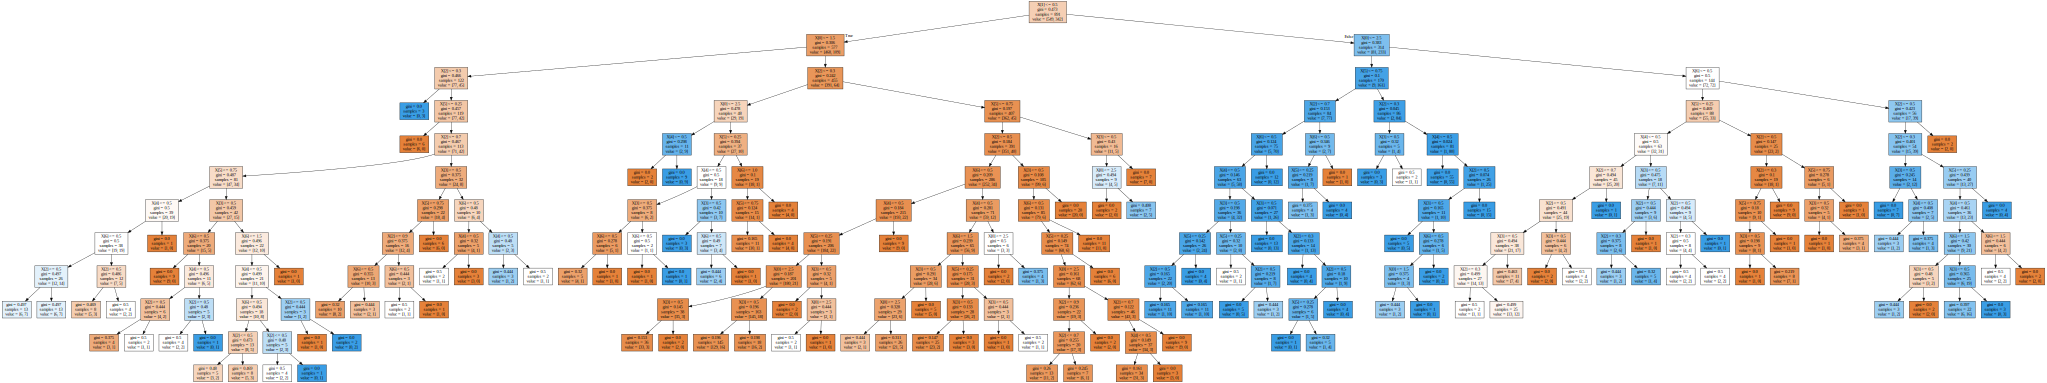

In [12]:
#Graph for SKLearn Decision Tree
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph